In [2]:
import tensorflow as tf

import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt

from typing import Tuple, List

In [3]:
import os
import sys
import pickle


def project_dir():
    notebook_path = %pwd
    repo_name = "sisi"
    repo_folder = notebook_path.split(repo_name)[0]
    return os.path.join(repo_folder, repo_name)


pwd = os.getenv("PWD", project_dir())
os.environ["PWD"] = pwd
sys.path.append(pwd)

In [5]:
from Utils.data_utils import get_data_and_country_list

In [6]:
def generate_dense_model(layers: List[int], output_len: int):
    
    model = tf.keras.models.Sequential()
    
    for units in layers:
        model.add(tf.keras.layers.Dense(units=units))
    
    model.add(tf.keras.layers.Dense(units=output_len*1))
    
    return model



def generate_data(df: pd.DataFrame, input_len: int, output_len: int, x_cols: List[str], y_cols: List[str], val_ratio: float):
    
    data_X = df.loc[:, x_cols].to_numpy().reshape(-1, len(x_cols))
    data_y = df.loc[:, y_cols].to_numpy().reshape(-1, len(y_cols))
    
    # maybe later :)
    # data_X = (data_X - data_X.mean(axis=0)) / data_X.std(axis=0)
    # data_y = (data_y - data_y.mean(axis=0)) / data_y.std(axis=0)
    
    X = []
    y = []

    for i in range(input_len, data_X.shape[0]-output_len):
        inp = data_X[i-input_len:i, :]
        out = data_y[i:i+output_len, :]
        X.append(inp)
        y.append(out)

    X = np.array(X).reshape(-1, input_len, len(x_cols))
    y = np.array(y).reshape(-1, output_len, len(y_cols))
    
    val_len = int(val_ratio * X.shape[0])
    train_X = X[:-val_len, ...]
    train_y = y[:-val_len, ...]
    val_X = X[-val_len:, ...]
    val_y = y[-val_len:, ...]
    
    return (train_X, train_y), (val_X, val_y)



def plot_history(history: tf.keras.callbacks.History):
    f, ax = plt.subplots(2, 1, figsize=(16,8))
    ax[0].plot(history.history["loss"], label="train")
    ax[0].plot(history.history["val_loss"], label="val")
    ax[0].set_title("MSE Loss")
    ax[0].legend()
    ax[1].plot(history.history["mean_absolute_error"], label="train")
    ax[1].plot(history.history["val_mean_absolute_error"], label="val")
    ax[1].set_title("MAE Loss")
    ax[1].legend()
    plt.show()



def compile_and_fit(model: tf.keras.Model, X: np.ndarray, y: np.ndarray, val: Tuple[np.ndarray], max_epochs: int = 20, patience: int = 2, verbose: int = 0):

    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience, mode='min', restore_best_weights=True)
    model.compile(loss="mse", optimizer="adam", metrics=["mae"])
    history = model.fit(X, y, epochs=max_epochs, batch_size=4, validation_data=val, callbacks=[early_stopping], verbose=verbose)
    
    return history



def fit_dense(input_len: int, output_len: int, layers: List[int],
             df: pd.DataFrame, x_cols: List[str] = ..., y_cols: List[str] = ..., val_ratio: float = 0.2,
             max_epochs: int = 20, patience: int = 2, verbose: int = 0):
    
    if x_cols is Ellipsis:
        x_cols = ["carbon_per_MWh", "day_sin", "day_cos", "year_sin", "year_cos"]
    if y_cols is Ellipsis:
        y_cols = ["carbon_per_MWh"]
    
    dense = generate_dense_model(layers=layers, output_len=output_len)
    
    (X, y), (val_X, val_y) = generate_data(df=df, input_len=input_len, output_len=output_len, x_cols=x_cols, y_cols=y_cols, val_ratio=val_ratio)
    X = X.reshape(X.shape[0], -1)
    y = y.reshape(y.shape[0], -1)
    val_X = val_X.reshape(val_X.shape[0], -1)
    val_y = val_y.reshape(val_y.shape[0], -1)
    print([a.shape for a in (X, y, val_X, val_y)])

    history = compile_and_fit(model=dense, X=X, y=y, val=(val_X, val_y), max_epochs=max_epochs, patience=patience, verbose=verbose)
    plot_history(history=history)
    
    return_obj = {
        "model": dense,
        "history": history,
        "hp": {
            "input_len": input_len,
            "output_len": output_len,
            "layers": layers,
            "x_cols": x_cols,
            "y_cols": y_cols,
            "val_ratio": val_ratio,
            "max_epochs": max_epochs,
            "patience": patience
        }
    }
    
    return return_obj

In [7]:
df_list, state_list = get_data_and_country_list(pwd="..")



==== CH ====
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
[(18305, 840), (18305, 24), (4576, 840), (4576, 24)]
Train on 18305 samples, validate on 4576 samples
Epoch 1/50
18305/18305 [==============================] - 7s 398us/sample - loss: 0.0093 - mean_absolute_error: 0.0338 - val_loss: 1.1879e-04 - val_mean_absolute_error: 0.0083
Epoch 2/50
18305/18305 [==============================] - 7s 383us/sample - loss: 4.5223e-04 - mean_absolute_error: 0.0065 - val_loss: 1.1943e-07 - val_mean_absolute_error: 2.6331e-04
Epoch 3/50
18305/18305 [==============================] - 8s 412us/sample - loss: 4.3728e-06 - mean_absolute_error: 0.0011 - val_loss: 4.8655e-07 - val_mean_absolute_error: 5.3287e-04
Epoch 4/50
18305/18305 [==============================] - 7s 378us/sample - loss: 7.6200e-04 - mean_absolute_error: 0.0036 - val_loss: 8.1416e-07 - val_mean_absolute_error: 6.8179e-04
Epoch 5/50
18305/18305 [=============

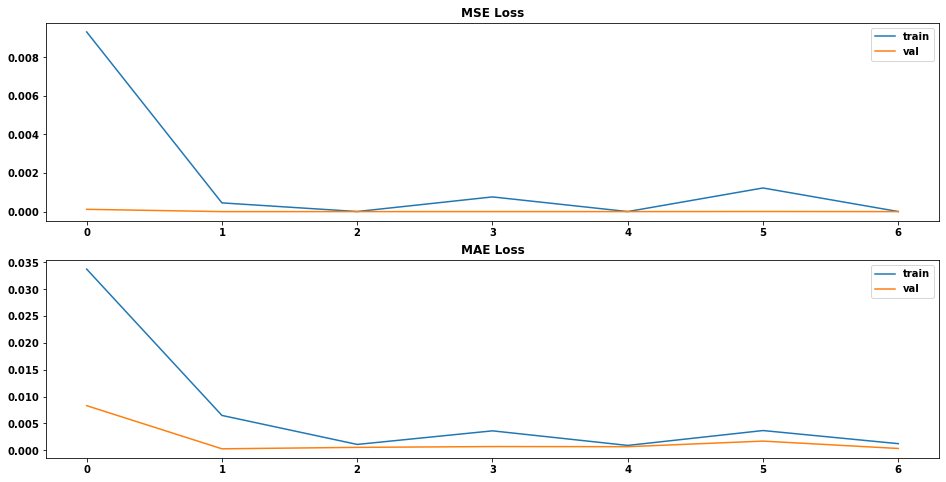



==== CZ ====
[(18305, 840), (18305, 24), (4576, 840), (4576, 24)]
Train on 18305 samples, validate on 4576 samples
Epoch 1/50
18305/18305 [==============================] - 8s 418us/sample - loss: 1957.9484 - mean_absolute_error: 31.7860 - val_loss: 961.7024 - val_mean_absolute_error: 23.9803
Epoch 2/50
18305/18305 [==============================] - 8s 425us/sample - loss: 1202.6414 - mean_absolute_error: 26.7326 - val_loss: 2543.4999 - val_mean_absolute_error: 41.9450
Epoch 3/50
18305/18305 [==============================] - 8s 418us/sample - loss: 1112.5468 - mean_absolute_error: 25.5452 - val_loss: 745.3833 - val_mean_absolute_error: 20.3614
Epoch 4/50
18305/18305 [==============================] - 8s 425us/sample - loss: 1044.5415 - mean_absolute_error: 24.7008 - val_loss: 860.8400 - val_mean_absolute_error: 22.4221
Epoch 5/50
18305/18305 [==============================] - 8s 421us/sample - loss: 1018.1824 - mean_absolute_error: 24.3692 - val_loss: 920.1896 - val_mean_absolute_er

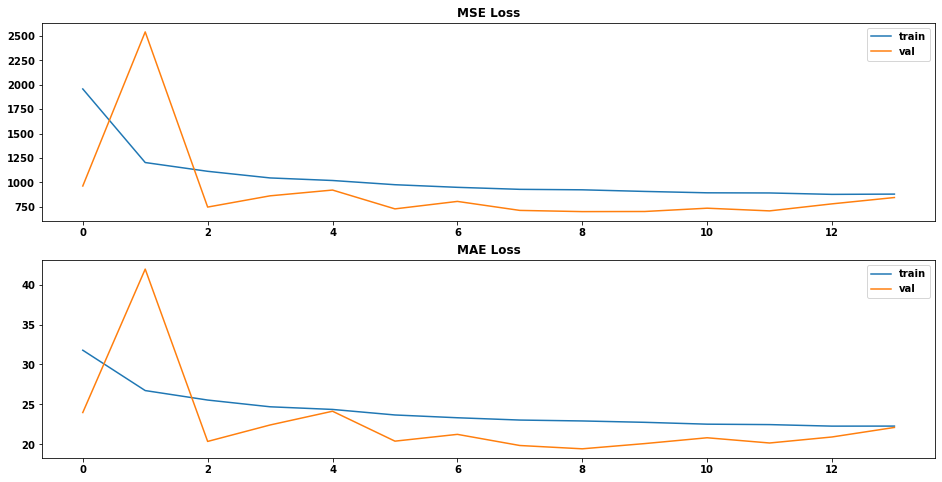



==== DK ====
[(18304, 840), (18304, 24), (4576, 840), (4576, 24)]
Train on 18304 samples, validate on 4576 samples
Epoch 1/50
18304/18304 [==============================] - 8s 443us/sample - loss: 8880.3221 - mean_absolute_error: 71.5999 - val_loss: 10859.3614 - val_mean_absolute_error: 81.4889
Epoch 2/50
18304/18304 [==============================] - 8s 417us/sample - loss: 7934.8262 - mean_absolute_error: 67.5496 - val_loss: 11211.8282 - val_mean_absolute_error: 83.0896
Epoch 3/50
18304/18304 [==============================] - 8s 414us/sample - loss: 7673.8157 - mean_absolute_error: 66.2161 - val_loss: 10989.0312 - val_mean_absolute_error: 82.6163
Epoch 4/50
18304/18304 [==============================] - 8s 414us/sample - loss: 7569.9597 - mean_absolute_error: 65.7100 - val_loss: 10363.5346 - val_mean_absolute_error: 77.5102
Epoch 5/50
18304/18304 [==============================] - 8s 419us/sample - loss: 7448.3283 - mean_absolute_error: 65.1109 - val_loss: 10609.8998 - val_mean_ab

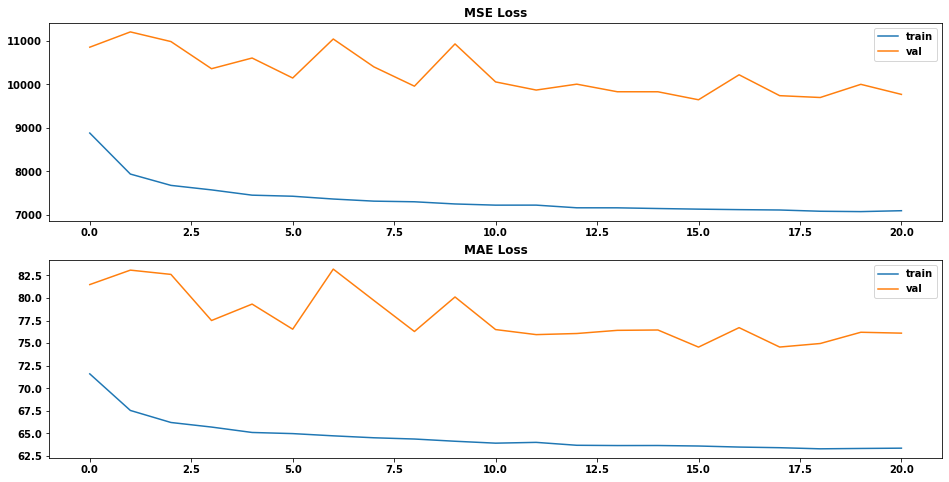



==== ES ====
[(18299, 840), (18299, 24), (4574, 840), (4574, 24)]
Train on 18299 samples, validate on 4574 samples
Epoch 1/50
18299/18299 [==============================] - 8s 432us/sample - loss: 741.7911 - mean_absolute_error: 20.6820 - val_loss: 887.9637 - val_mean_absolute_error: 23.3376
Epoch 2/50
18299/18299 [==============================] - 8s 430us/sample - loss: 599.3170 - mean_absolute_error: 18.6908 - val_loss: 734.6898 - val_mean_absolute_error: 20.4135
Epoch 3/50
18299/18299 [==============================] - 8s 438us/sample - loss: 562.2445 - mean_absolute_error: 17.9217 - val_loss: 962.3398 - val_mean_absolute_error: 23.8434
Epoch 4/50
18299/18299 [==============================] - 8s 464us/sample - loss: 541.1448 - mean_absolute_error: 17.6114 - val_loss: 775.9893 - val_mean_absolute_error: 21.4604
Epoch 5/50
18299/18299 [==============================] - 8s 437us/sample - loss: 534.1398 - mean_absolute_error: 17.4670 - val_loss: 760.6670 - val_mean_absolute_error: 2

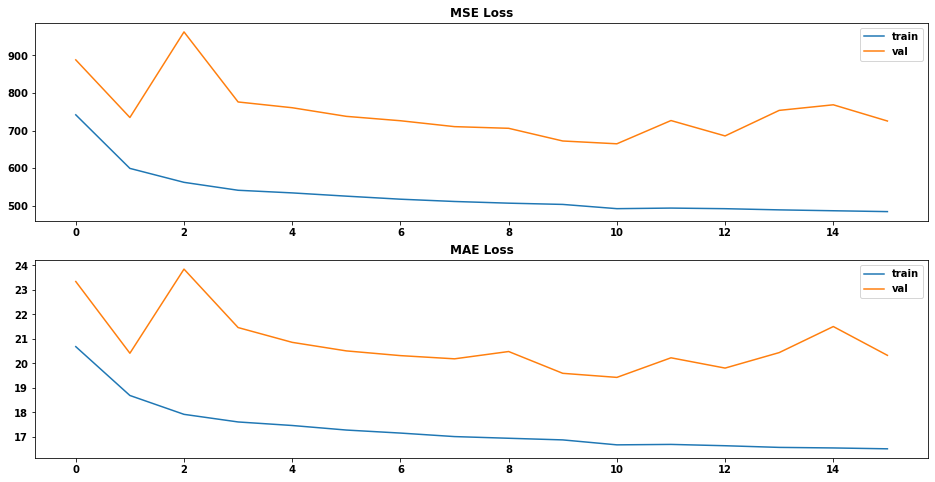



==== FI ====
[(18305, 840), (18305, 24), (4576, 840), (4576, 24)]
Train on 18305 samples, validate on 4576 samples
Epoch 1/50
18305/18305 [==============================] - 8s 446us/sample - loss: 657.9839 - mean_absolute_error: 18.5520 - val_loss: 535.9163 - val_mean_absolute_error: 17.1995
Epoch 2/50
18305/18305 [==============================] - 9s 504us/sample - loss: 512.6240 - mean_absolute_error: 16.6212 - val_loss: 487.2480 - val_mean_absolute_error: 16.0360
Epoch 3/50
18305/18305 [==============================] - 8s 437us/sample - loss: 490.4370 - mean_absolute_error: 16.1813 - val_loss: 438.5861 - val_mean_absolute_error: 15.1618
Epoch 4/50
18305/18305 [==============================] - 10s 528us/sample - loss: 466.6988 - mean_absolute_error: 15.7186 - val_loss: 452.6906 - val_mean_absolute_error: 15.4736
Epoch 5/50
18305/18305 [==============================] - 8s 439us/sample - loss: 449.9246 - mean_absolute_error: 15.3940 - val_loss: 553.8188 - val_mean_absolute_error: 

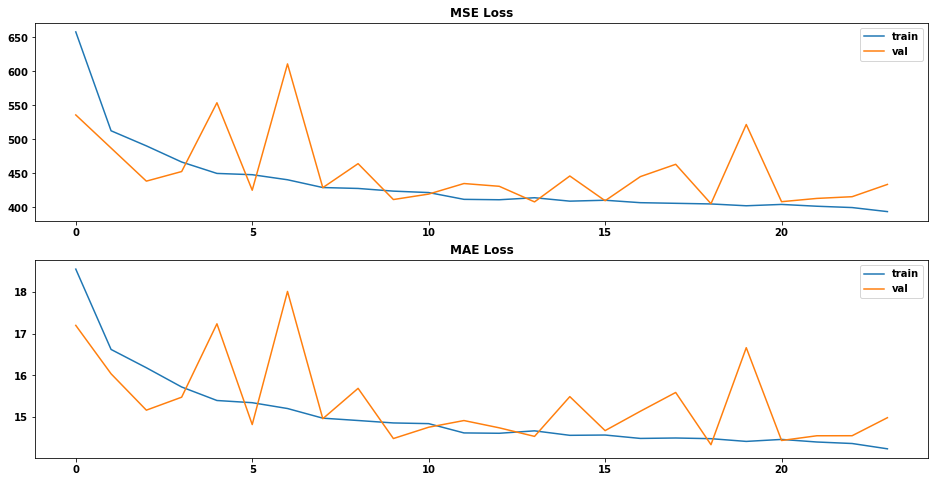



==== FR ====
[(18295, 840), (18295, 24), (4573, 840), (4573, 24)]
Train on 18295 samples, validate on 4573 samples
Epoch 1/50
18295/18295 [==============================] - 8s 458us/sample - loss: 102.8971 - mean_absolute_error: 7.3661 - val_loss: 93.8270 - val_mean_absolute_error: 7.0904
Epoch 2/50
18295/18295 [==============================] - 8s 454us/sample - loss: 82.9370 - mean_absolute_error: 6.6668 - val_loss: 138.2055 - val_mean_absolute_error: 8.9359
Epoch 3/50
18295/18295 [==============================] - 8s 452us/sample - loss: 78.9797 - mean_absolute_error: 6.4894 - val_loss: 95.0105 - val_mean_absolute_error: 7.2466
Epoch 4/50
18295/18295 [==============================] - 8s 451us/sample - loss: 75.7814 - mean_absolute_error: 6.3403 - val_loss: 88.2623 - val_mean_absolute_error: 6.8671
Epoch 5/50
18295/18295 [==============================] - 8s 451us/sample - loss: 74.7113 - mean_absolute_error: 6.2798 - val_loss: 118.1954 - val_mean_absolute_error: 8.1445
Epoch 6/50

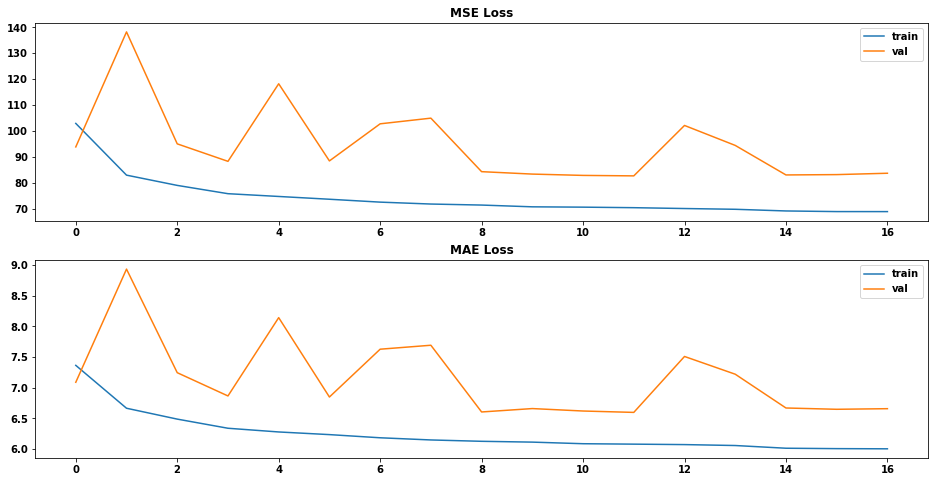



==== IT ====
[(18305, 840), (18305, 24), (4576, 840), (4576, 24)]
Train on 18305 samples, validate on 4576 samples
Epoch 1/50
18305/18305 [==============================] - 9s 485us/sample - loss: 1284.4913 - mean_absolute_error: 27.1090 - val_loss: 1151.5795 - val_mean_absolute_error: 26.9320
Epoch 2/50
18305/18305 [==============================] - 9s 469us/sample - loss: 904.6659 - mean_absolute_error: 23.5720 - val_loss: 918.8575 - val_mean_absolute_error: 24.2300
Epoch 3/50
18305/18305 [==============================] - 9s 469us/sample - loss: 838.9212 - mean_absolute_error: 22.6457 - val_loss: 750.7867 - val_mean_absolute_error: 21.1722
Epoch 4/50
18305/18305 [==============================] - 8s 459us/sample - loss: 794.1025 - mean_absolute_error: 21.9435 - val_loss: 963.4472 - val_mean_absolute_error: 24.1486
Epoch 5/50
18305/18305 [==============================] - 9s 470us/sample - loss: 782.8528 - mean_absolute_error: 21.7889 - val_loss: 770.1924 - val_mean_absolute_error:

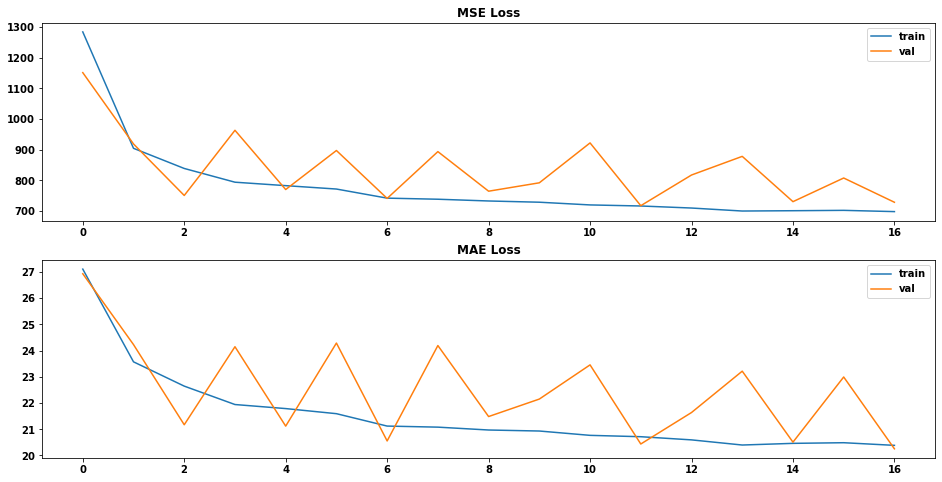



==== PL ====
[(18305, 840), (18305, 24), (4576, 840), (4576, 24)]
Train on 18305 samples, validate on 4576 samples
Epoch 1/50
18305/18305 [==============================] - 9s 475us/sample - loss: 7305.5532 - mean_absolute_error: 64.0078 - val_loss: 4289.3463 - val_mean_absolute_error: 51.7636
Epoch 2/50
18305/18305 [==============================] - 9s 475us/sample - loss: 4864.4286 - mean_absolute_error: 54.7769 - val_loss: 3769.0670 - val_mean_absolute_error: 47.0391
Epoch 3/50
18305/18305 [==============================] - 8s 462us/sample - loss: 4564.7415 - mean_absolute_error: 52.9759 - val_loss: 3715.4996 - val_mean_absolute_error: 47.8721
Epoch 4/50
18305/18305 [==============================] - 8s 463us/sample - loss: 4282.1270 - mean_absolute_error: 51.1354 - val_loss: 7963.2981 - val_mean_absolute_error: 77.1054
Epoch 5/50
18305/18305 [==============================] - 8s 457us/sample - loss: 4104.4778 - mean_absolute_error: 49.8439 - val_loss: 3669.8699 - val_mean_absolut

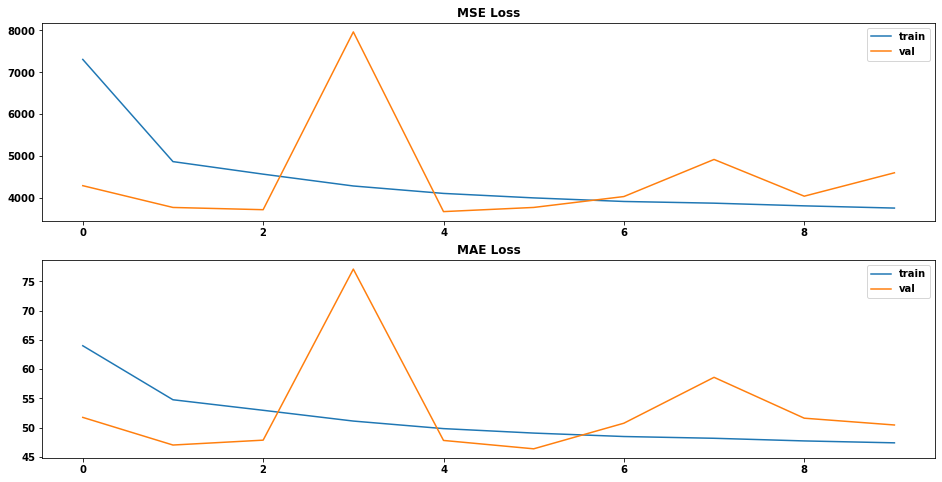



==== SE ====
[(18305, 840), (18305, 24), (4576, 840), (4576, 24)]
Train on 18305 samples, validate on 4576 samples
Epoch 1/50
18305/18305 [==============================] - 9s 487us/sample - loss: 0.0180 - mean_absolute_error: 0.0499 - val_loss: 3.5872e-04 - val_mean_absolute_error: 0.0145
Epoch 2/50
18305/18305 [==============================] - 9s 485us/sample - loss: 0.0075 - mean_absolute_error: 0.0236 - val_loss: 0.0044 - val_mean_absolute_error: 0.0442
Epoch 3/50
18305/18305 [==============================] - 9s 473us/sample - loss: 0.0073 - mean_absolute_error: 0.0213 - val_loss: 6.6878e-04 - val_mean_absolute_error: 0.0179
Epoch 4/50
18305/18305 [==============================] - 9s 482us/sample - loss: 0.0072 - mean_absolute_error: 0.0201 - val_loss: 6.9664e-06 - val_mean_absolute_error: 0.0021
Epoch 5/50
18305/18305 [==============================] - 9s 475us/sample - loss: 0.0066 - mean_absolute_error: 0.0180 - val_loss: 3.8057e-05 - val_mean_absolute_error: 0.0048
Epoch 6

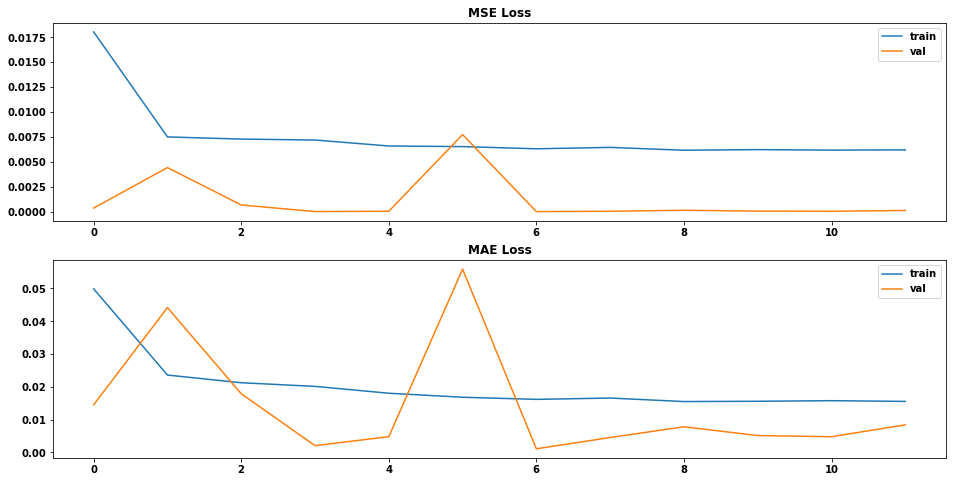

In [8]:
# settings

day_hours = 24 * 60 * 60
year_hours = 365.2425 * day_hours

input_len = 7 * 24
output_len = 24
layers = [256, 64, 32]
max_epochs = 50
patience = 5


# getting predictions

preds_list = []

for df, state in zip(df_list, state_list):
    
    print(f"\n\n==== {state} ====")
    
    # dataframe preparation
    
    df.datetime = pd.to_datetime(df.datetime)
    timestamp_s = df.datetime.map(dt.datetime.timestamp)

    df['day_sin'] = np.sin(timestamp_s * (2 * np.pi / day_hours))
    df['day_cos'] = np.cos(timestamp_s * (2 * np.pi / day_hours))
    df['year_sin'] = np.sin(timestamp_s * (2 * np.pi / year_hours))
    df['year_cos'] = np.cos(timestamp_s * (2 * np.pi / year_hours))

    df = df.fillna(value=0)

    df_train = df.loc[df.datetime.dt.year < 2022]


    # training model

    week2day = fit_dense(input_len=input_len, output_len=output_len, layers=layers, df=df_train, max_epochs=max_epochs, patience=patience, verbose=1)


    # generating predictions
    
    model = week2day["model"]
    hp = week2day["hp"]
    input_len = hp["input_len"]
    output_len = hp["output_len"]
    x_cols = hp["x_cols"]
    y_cols = hp["y_cols"]

    df_test = df.loc[(df.datetime + dt.timedelta(hours=hp["input_len"])).dt.year >= 2022]
    data_X = df_test.loc[:, x_cols].to_numpy()

    test_X = []
    for i in range(input_len, data_X.shape[0], output_len):
        inp = data_X[i-input_len:i, ...].ravel()
        test_X.append(inp)

    test_X = np.array(test_X)
    
    
    # saving predictions to dict
    
    timestamps = df.loc[df.datetime.dt.year >= 2022, "datetime"]
    preds = model.predict(test_X).ravel()
    preds_dict = {t: p for t, p in zip(timestamps, preds)}
    
    preds_list.append(preds_dict)

In [9]:
with open("../data/predictions/dnn_pred_eu.pkl", "wb") as f:
    pickle.dump(preds_list, f)